In [74]:
import ccxt
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
import numpy as np
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential


ex = ccxt.cryptocom()

# download data from crypto.com exchange spot market
df = pd.DataFrame(
    ex.fetch_ohlcv(symbol='BTC/USDT', timeframe='1d', limit=1000), 
    columns = ['unix', 'open', 'high', 'low', 'close', 'volume']
)

# convert unix (in milliseconds) to UTC time
df['date'] = pd.to_datetime(df.unix, unit='ms')

In [145]:
def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len + 1
    return np.array([data[i:(i+seq_len)] for i in range(n_seq)])

In [146]:
def get_train_test_sets(data, seq_len, train_frac):
    sequences = split_into_sequences(data, seq_len)
    n_train = int(sequences.shape[0] * train_frac)
    x_train = sequences[:n_train, :-1, :]
    y_train = sequences[:n_train, -1, :]
    x_test = sequences[n_train:, :-1, :]
    y_test = sequences[n_train:, -1, :]
    return x_train, y_train, x_test, y_test

In [13]:
directory = dir(ccxt.cryptocom())

In [15]:
for dir in directory:
    print (dir)

__class__
__del__
__delattr__
__dict__
__dir__
__doc__
__eq__
__format__
__ge__
__getattribute__
__gt__
__hash__
__init__
__init_subclass__
__le__
__lt__
__module__
__ne__
__new__
__reduce__
__reduce_ex__
__repr__
__setattr__
__sizeof__
__str__
__subclasshook__
__weakref__
account
accounts
aggregate
aiohttpProxy
aiohttpTrustEnv
aiohttp_proxy
aiohttp_trust_env
alias
amountToPrecision
amount_to_precision
api
apiKey
arrayConcat
arraySlice
array_concat
assignDefaultDepositWithdrawFees
assign_default_deposit_withdraw_fees
asyncioLoop
asyncio_loop
balance
base16ToBinary
base16_to_binary
base58Alphabet
base58Decoder
base58Encoder
base58ToBinary
base58_alphabet
base58_decoder
base58_encoder
base58_to_binary
base64ToBinary
base64ToString
base64_to_binary
base64_to_string
base64urlencode
baseCurrencies
base_currencies
binaryConcat
binaryConcatArray
binaryToBase16
binaryToBase58
binaryToBase64
binary_concat
binary_concat_array
binary_to_base16
binary_to_base58
binary_to_base64
borrowMargin
borrow

In [25]:
print(ex.fetch_tickers()) # all tickers indexed by their symbols

{'MATIC/USDT': {'symbol': 'MATIC/USDT', 'timestamp': 1683539713955, 'datetime': '2023-05-08T09:55:13.955Z', 'high': 0.98471, 'low': 0.92183, 'bid': 0.93546, 'bidVolume': None, 'ask': 0.93614, 'askVolume': None, 'vwap': None, 'open': 0.97676, 'close': 0.93596, 'last': 0.93596, 'previousClose': None, 'change': -0.0408, 'percentage': None, 'average': None, 'baseVolume': 390428.8001, 'quoteVolume': None, 'info': {'i': 'MATIC_USDT', 'h': '0.98471', 'l': '0.92183', 'a': '0.93596', 'v': '390428.8001', 'vv': '370623.32', 'c': '-0.0408', 'b': '0.93546', 'k': '0.93614', 't': '1683539713955'}}, 'QI-D36500': {'symbol': 'QI-D36500', 'timestamp': 0, 'datetime': '1970-01-01T00:00:00.000Z', 'high': None, 'low': None, 'bid': None, 'bidVolume': None, 'ask': None, 'askVolume': None, 'vwap': None, 'open': None, 'close': None, 'last': None, 'previousClose': None, 'change': 0.0, 'percentage': None, 'average': None, 'baseVolume': 0.0, 'quoteVolume': None, 'info': {'i': 'QI-D36500', 'h': '0', 'l': '0', 'a': '

Text(0.5, 1.0, 'BTC Daily Close Price')

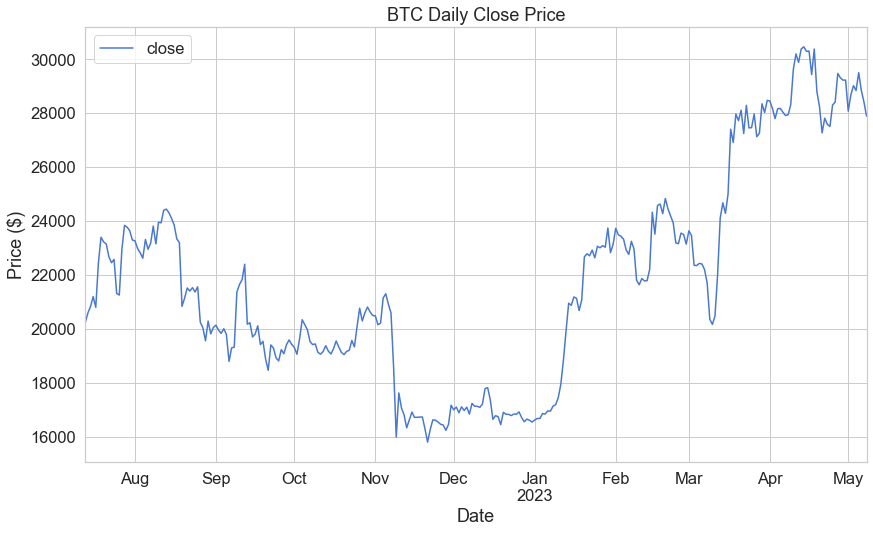

In [26]:
%matplotlib inline


rcParams['figure.figsize'] = 14, 8
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

# data plot
ax = df.plot(x='date', y='close');
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.set_title('BTC Daily Close Price')

In [83]:
#Pre-processing data 

scaler = MinMaxScaler() 
# fit the format of the scaler -> convert shape from (1000, ) -> (1000, 1)
close_price = df.close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

In [144]:
seq_len = 30

In [147]:
#Building Training / Testing data sets
x_train, y_train, x_test, y_test = get_train_test_sets(scaled_close, seq_len, train_frac=0.9)

In [148]:
# fraction of the input to drop; helps prevent overfitting
dropout = 0.5
window_size = seq_len - 1

# build a 3-layer LSTM RNN
model = keras.Sequential()

model.add(LSTM(window_size, return_sequences=True, input_shape=(window_size, x_train.shape[-1])))

model.add(Dropout(rate=dropout))
# Bidirectional allows for training of sequence data forwards and backwards
model.add( Bidirectional(LSTM((window_size * 2), return_sequences=True))) 

model.add(Dropout(rate=dropout))
model.add(Bidirectional(LSTM(window_size, return_sequences=False))) 

model.add(Dense(units=1))
# linear activation function: activation is proportional to the input
model.add(Activation('linear'))

In [149]:
batch_size = 32

model.compile( loss= 'mean_squared_error', optimizer='adam')

history = model.fit(x_train, y_train, epochs=7,batch_size=batch_size,
    shuffle=False,
    validation_split=0.2)

Epoch 1/7
3/3 [==============================] - 53s 14s/step - loss: 0.1222 - val_loss: 0.0533
Epoch 2/7
3/3 [==============================] - 45s 15s/step - loss: 0.1135 - val_loss: 0.3710
Epoch 3/7
3/3 [==============================] - 45s 14s/step - loss: 0.0815 - val_loss: 0.0612
Epoch 4/7
3/3 [==============================] - 48s 15s/step - loss: 0.0251 - val_loss: 0.0108
Epoch 5/7
3/3 [==============================] - 46s 15s/step - loss: 0.0528 - val_loss: 0.0570
Epoch 6/7
3/3 [==============================] - 47s 15s/step - loss: 0.0297 - val_loss: 0.0698
Epoch 7/7
3/3 [==============================] - 46s 15s/step - loss: 0.0174 - val_loss: 0.0117


In [150]:
y_pred = model.predict(x_test)

1/1 [==============================] - 5s 5s/step


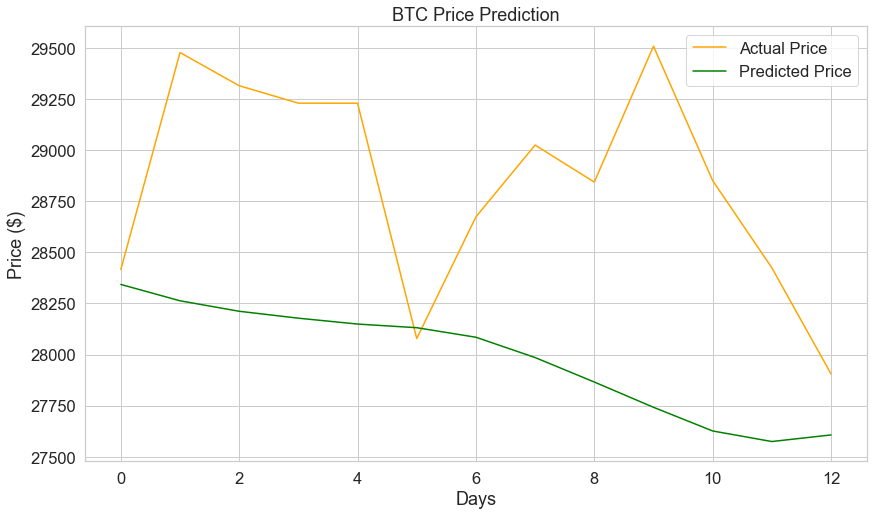

In [151]:


# invert the scaler to get the absolute price data
y_test_orig = scaler.inverse_transform(y_test)
y_pred_orig = scaler.inverse_transform(y_pred)

# plots of prediction against actual data
plt.plot(y_test_orig, label='Actual Price', color='orange')
plt.plot(y_pred_orig, label='Predicted Price', color='green')
 
plt.title('BTC Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.legend(loc='best')

plt.show();



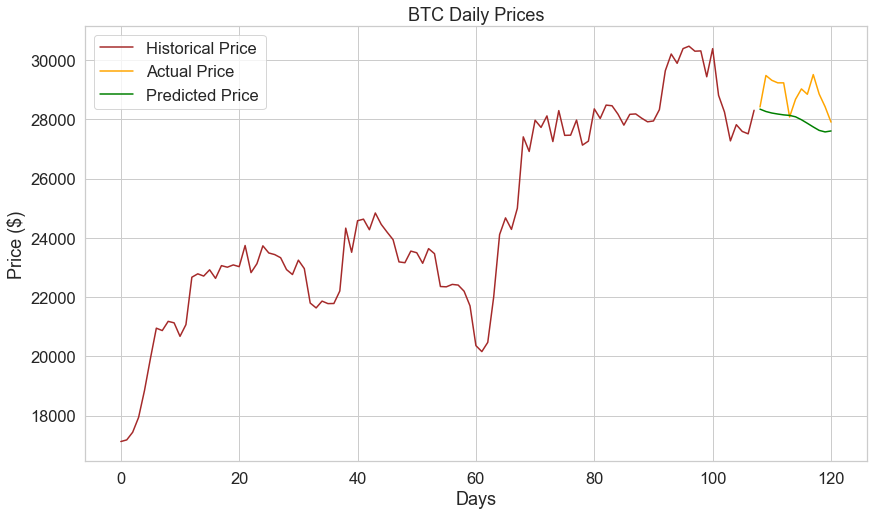

In [152]:
# plot for whole range of data
plt.plot(np.arange(0, len(y_train)), scaler.inverse_transform(y_train), color='brown', label='Historical Price')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test_orig)), y_test_orig, color='orange', label='Actual Price')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred_orig)), y_pred_orig, color='green', label='Predicted Price')

plt.title('BTC Daily Prices')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.legend()
plt.show();

In [ ]:
#Code Source Credit:https://medium.com/codex/time-series-prediction-using-lstm-in-python-19b1187f580f